# **2.0 Data Cleaning**

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [120]:
# Load the healthcare dataset into a Pandas DataFrame
DATA_DIR_1 = "/content/healthcare data2.csv"
df = pd.read_csv(DATA_DIR_1, header = 0)
ori_df = pd.read_csv(DATA_DIR_1, header = 0)

In [48]:
# Implement line wrapping
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <Style>
    pre{
      white-space: pre-wrapped;
    }
  </Style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [49]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [50]:
df.shape

(318438, 18)

## **2.1 Remove Data Points Irrelevent to the Research Questions**

In [121]:
# Remove unwanted data points that is irrelevant to the analysis
df = df.drop(['case_id', "City_Code_Hospital", "Available Extra Rooms in Hospital",
              "Bed Grade", "Admission_Deposit",
              "Hospital_region_code", "Department", "Ward_Facility_Code",
              "patientid", "City_Code_Patient"], axis=1)
df.columns

Index(['Hospital_code', 'Hospital_type_code', 'Ward_Type', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age', 'Stay'],
      dtype='object')

## **2.2 Handling Duplicates.**

In [52]:
# Remove duplicates
df = df.drop_duplicates()

Any present duplicate row is fropped using the pandas drop_duplicates() function, as shown in the code above.

In [53]:
df.shape

(81574, 8)

As shown from the shape output above, the number of rows has significantly decreased from 318438 to 81574 after duplicate rows have been dropped.

## **2.3 Handling Outliers**

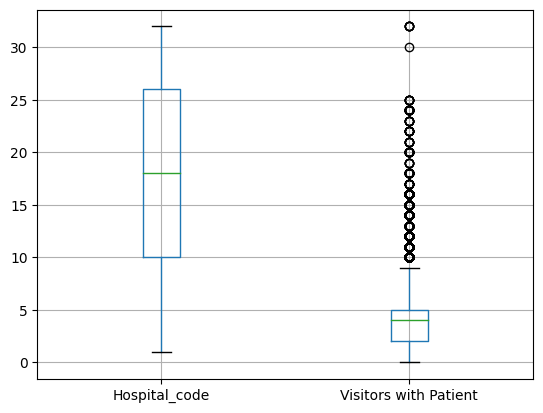

In [54]:
# Select the numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64'])
# Plot boxplots for the numerical columns
num_cols.boxplot()
plt.show()


By visualizing the numerical columns as a box plot using the matplotlib boxplot() function, it can be observed that outliers are present in the visitors with patient column.

In [55]:
# Initializing list to store initial medians and STDs
old_median = 0
old_std = 0

In [56]:
# Checking for outliers
stats = num_cols.describe()
outliers = {}
for c in num_cols.columns:
  median = df[c].median()
  std = df[c].std()
  old_median = median
  old_std = std
  outliers = (df[c] < (median - 3*std)) | (df[c] > (median + 3*std))
  print(outliers.value_counts())

False    81574
Name: Hospital_code, dtype: int64
False    80124
True      1450
Name: Visitors with Patient, dtype: int64


By considering values that are 3 standard deviations away from the median as outliers, it can be observed in the output above that the "Visitors with Patient" column contains 1450 outliers.

In [57]:
# Replacing outlier values with median
median = df["Visitors with Patient"].median()
std = df["Visitors with Patient"].std()
lower = median - 3 * std
upper = median + 3 * std
df[c] = df[c].mask((df[c] < lower) | (df[c] > upper), median)


To handle the outliers, they can be replaced with the column's median suing the pandas mask() function so as to not affect the sample size.

In [58]:
# Checking if all outliers have been replaced
lower = old_median - 3 * old_std
upper = old_median + 3 * old_std
outliers = (df[c] < lower) | (df[c] > upper)
print(outliers.value_counts())
print("Number of rows in dataset:", df.shape[0])

False    81574
Name: Visitors with Patient, dtype: int64
Number of rows in dataset: 81574


The old median and standard deviation values are used to check if all outliers have been replaced because if the new values are used, new outliers might be detected due to the change in the distribution.

From the output above, it can be observed by the absence of "True" values that all outliers have been handled.

## **2.4 Handling Missing Values**

In [62]:
# Check missing values for each column
print(df.isna().sum())

Hospital_code            0
Hospital_type_code       0
Ward_Type                0
Type of Admission        0
Severity of Illness      0
Visitors with Patient    0
Age                      0
Stay                     0
dtype: int64


Since no missing value is present in the dataset, there is no need to fill in the missing values.

## **2.5 Balancing Distribution using Over-sampling**

To balance a dataset using over-sampling, the distribution of the target variable must first be investigated and since this assignment requires binary classification, a target variable based on the stay value can be created, namely "Stay_Type", which will detail whether a patient stayed for a short duration or long duration.

But in order to do so, the unique values of the "Stay" column must first be investigated.

In [63]:
df["Stay"].value_counts()

31-40                 14527
11-20                 13017
51-60                 12295
21-30                 12136
0-10                   6817
71-80                  5729
41-50                  5590
More than 100 Days     4214
81-90                  3207
61-70                  2045
91-100                 1997
Name: Stay, dtype: int64

The value_counts() output above shows the distribution of each unique Stay value.

In [64]:
# Define the mapping dictionary
mapping = {'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3,
           '41-50': 4, '51-60':5, '61-70':6, '71-80':7, '81-90':8,
           '91-100':9, 'More than 100 Days':10}

# Label Encoding
# Replace the categorical values with numerical values
df['Stay'] = df['Stay'].replace(mapping)

In order to facilitate the creation of the target, the Stay column is first label encoded using the replace() function to apply the mapping shown above.

In [65]:
# Creating a binary target variable due to assignment requirements
# for the keras neural network
df['Stay_Type'] = df['Stay'].apply(lambda x: 1 if x >=5 else 0)
df["Stay_Type"].value_counts()

0    52087
1    29487
Name: Stay_Type, dtype: int64

The target variable Stay_Type is then created based on the respective Stay column value, where a stay value lower than 5 will result in a 0 and higher or equal to 5 will result in a 1.

From the value_counts() output above, it can be observed that the value 0 makes up for a majority of the Stay_Type distribution.

In [66]:
# Define the majority and minority class
majority_class = df[df["Stay_Type"] == 0]
minority_class = df[df["Stay_Type"] == 1]

The majority and minority class subsets are created based on the "df["Stay_Type"].value_counts()" output.

In [67]:
from sklearn.utils import resample
# Define the number of samples to generate for each minority class
n_samples = len(majority_class)
# Define the random state for reproducibility
random_state = 42
# Create an empty list to store the oversampled data
oversampled_data = []
# Loop over the minority classes and apply oversampling
oversampled_minority = resample(minority_class,
                                replace = True,
                                n_samples=n_samples,
                                random_state=random_state)


# Concatenate the oversampled data with the majority data
oversampled_data = pd.concat([majority_class, oversampled_minority])
oversampled_data = oversampled_data.sample(frac=1, random_state=42)
oversampled_data["Stay_Type"].value_counts()

1    52087
0    52087
Name: Stay_Type, dtype: int64

By using the resample() function from the sci-kit learn library, additional data rows of the minority class is created to match the number of rows in the majority class. The over-sampled minority class subset is then concatenated with the majority class subset using the concat() function to create the balanced dataset.

In [68]:
print("Before over-sampling", df.shape)
print("Number of rows in majority class:", majority_class.shape[0])
print("After over-sampling", oversampled_data.shape)

Before over-sampling (81574, 9)
Number of rows in majority class: 52087
After over-sampling (104174, 9)


As shown in the output above, the dataset row count has increased due to the minority class column count increasing to match the majority class, where the dataset row count is now double the number of rows in the majority class.

# **3.0 Data Exploration**

In [34]:
# Import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sb

## **3.1 Investigating shape of dataset**

In [69]:
# Comparing the distribution of original and cleaned dataset
print("Original Dataset Shape:", ori_df.shape)
print("Dataset shape after cleaning:", oversampled_data.shape)

Original Dataset Shape: (318438, 18)
Dataset shape after cleaning: (104174, 9)


As shown in the output above, the dataset originally has 318438 rows and 18 columns but after cleaning the dataset where irrelevant data points were dropped and over-sampling was carried out, the dataset set now has 9 columns with 104174 rows.

## **3.2 Exploring the distribution of variables**

In [70]:
# Getting the distribution of each variable
for col in oversampled_data.columns:
  print("Distribution of", col, "column:")
  print(oversampled_data[col].value_counts())
  print()

Distribution of Hospital_code column:
26    9542
23    7038
14    5678
6     5096
9     4818
12    4627
27    4501
29    4174
11    4155
25    4050
15    3983
28    3418
21    3409
10    3268
3     3055
1     2900
19    2844
18    2387
5     2362
32    2358
30    2317
16    2282
24    2271
31    2270
22    2243
2     2082
8     1851
13    1594
17    1551
20     871
7      619
4      560
Name: Hospital_code, dtype: int64

Distribution of Hospital_type_code column:
a    41364
c    21249
b    17986
d    10105
e     8869
f     2358
g     2243
Name: Hospital_type_code, dtype: int64

Distribution of Ward_Type column:
R    40115
Q    30158
S    29285
P     3430
T     1177
U        9
Name: Ward_Type, dtype: int64

Distribution of Type of Admission column:
Trauma       43814
Emergency    38962
Urgent       21398
Name: Type of Admission, dtype: int64

Distribution of Severity of Illness column:
Moderate    47118
Minor       30347
Extreme     26709
Name: Severity of Illness, dtype: int64

Distrib

From the output above, the following inferences can be made:


*   In the Hospital_Code column, code 4 and 7 make up the minority of the distribution with a count of 560 and 619 respectively, where there is a small disparity between them when compared with other codes.
*   In the Hospital_type_code column, type f and g make up the minority of the distribution with a count of 2243 and 2358 respectively, where there is a small disparity between them when compared with other types.
*   In the ward_type column, the type U can be considered an outlier as it only has 9 instances while the other types are in the thousands.
*   In Type of admission column, the urgent type seems to be the minority, with the majority type having almost twice the amount of instances.
*   The same as the previous point can be said about the Extreme severity in the severity of illness column
*   The 0 number of visitors in the visitor with patient column and the 91-100 age range seem to be the obvious minority in their respective columns.
*   In the stay column, most platients seem to be staying between 51 and 60 days while the minority of patients seem to be staying between 91 to 100 days.




In [71]:
# Extracting numerical columns
numerical_cols = oversampled_data.select_dtypes(include=["float", "int"]).columns
numerical_cols

Index(['Hospital_code', 'Visitors with Patient', 'Stay', 'Stay_Type'], dtype='object')

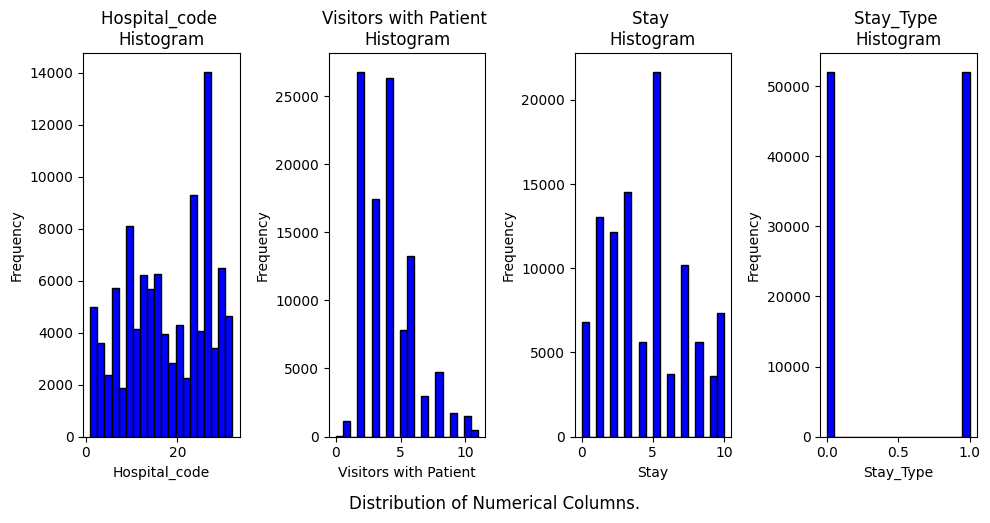

In [124]:
# Visualizing numerical columns as histograms
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axs = axs.flatten() # Make a single axis to facilitate plotting using for loop
for i in range(len(numerical_cols)):
  ax = axs[i]
  ax.hist(oversampled_data[numerical_cols[i]], bins = 20, color="blue",
          edgecolor="black")
  ax.set_title(numerical_cols[i] + " \nHistogram")
  ax.set_ylabel("Frequency")
  ax.set_xlabel(numerical_cols[i])

for j in range(len(numerical_cols), len(axs)):
  fig.delaxes(axs[j])

fig.tight_layout()
plt.suptitle("Distribution of Numerical Columns.", y = 0)
plt.show()


By visualizing the numerical columns as histograms, it can be observed that both the stay and visitors with patient colummns have a right skewed distribution while the hospital_code column has a left skewed distribution.

As expected, the stay_type column has a balanced distribution due to the oversampling carried out.

## **3.3 Exploring the relationship between the variables.**

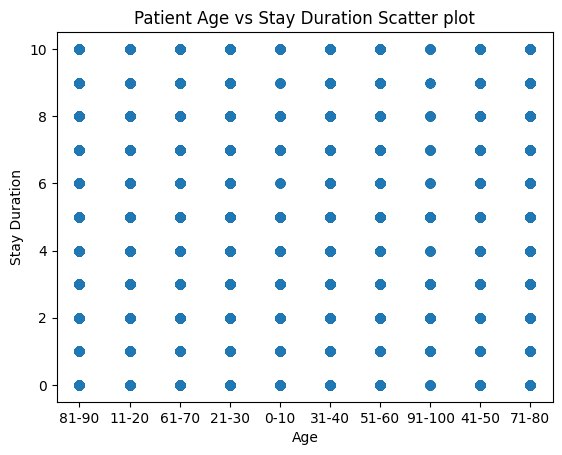

In [100]:
# Visualizing the relationship between age and stay duration as a scatter plot
plt.scatter(oversampled_data["Age"], oversampled_data["Stay"], marker = "o")
plt.title("Patient Age vs Stay Duration Scatter plot")
plt.xlabel("Age")
plt.ylabel("Stay Duration")
plt.show()

From the scatter plot above, it can be observed that there is a total absence of linearity between the patient's age and their stay durstion due to the lack of any pattern resembling a straight line formed by the points.

Henced it can be determined that the patient's age does not affect their stay duration in a linear way.

In [101]:
# Initialize category and value list
categories = []
values_list = []

In [102]:
# Preparing the values and categories to plot barcharts
for cat in np.sort(oversampled_data["Severity of Illness"].unique().astype(str)):
  categories.append(cat)
  s0 = oversampled_data[(oversampled_data["Stay"] == 0) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s1 = oversampled_data[(oversampled_data["Stay"] == 1) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s2 = oversampled_data[(oversampled_data["Stay"] == 2) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s3 = oversampled_data[(oversampled_data["Stay"] == 3) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s4 = oversampled_data[(oversampled_data["Stay"] == 4) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s5 = oversampled_data[(oversampled_data["Stay"] == 5) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s6 = oversampled_data[(oversampled_data["Stay"] == 6) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s7 = oversampled_data[(oversampled_data["Stay"] == 7) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s8 = oversampled_data[(oversampled_data["Stay"] == 8) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s9 = oversampled_data[(oversampled_data["Stay"] == 9) &
                             (oversampled_data["Severity of Illness"] == cat)]
  s10 = oversampled_data[(oversampled_data["Stay"] == 10) &
                             (oversampled_data["Severity of Illness"] == cat)]
  value = [len(s0), len(s1), len(s2), len(s3), len(s4), len(s5), len(s6), len(s7), len(s8), len(s9), len(s10)]
  values_list.append(value)

<ipython-input-110-345b7513e6ec>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stay_cat, rotation = "vertical")


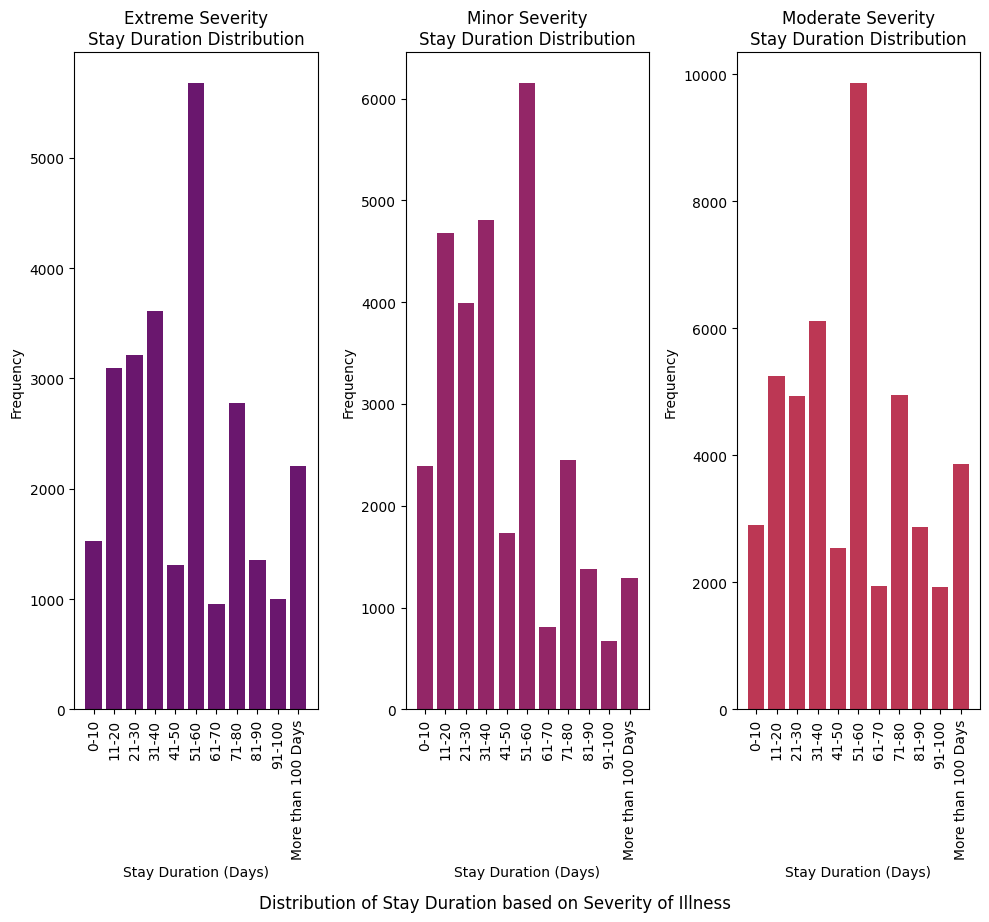

In [110]:
# Visualizing the relationship between the severity of illness and stay duration
# as bar charts
stay_cat = ['0-10', '11-20', '21-30', '31-40',
           '41-50', '51-60', '61-70', '71-80', '81-90',
           '91-100', 'More than 100 Days']
color_map = plt.get_cmap("inferno", 11)
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10,9))
axs = axs.flatten()

for i in range(len(categories)):
  ax = axs[i]
  ax.bar(stay_cat, values_list[i], color=color_map(i+3))
  ax.set_title(categories[i] + " Severity\nStay Duration Distribution")
  ax.set_ylabel("Frequency")
  ax.set_xlabel("Stay Duration (Days)")
  ax.set_xticklabels(stay_cat, rotation = "vertical")

fig.tight_layout()
plt.suptitle("Distribution of Stay Duration based on Severity of Illness", y = 0)
plt.show()

From the bar charts above, it can be observed no matter the severity of illness, the distribution of the stay duration stays more or less the same, which infers that the severity of illness has close to no correlation to the stay duration.

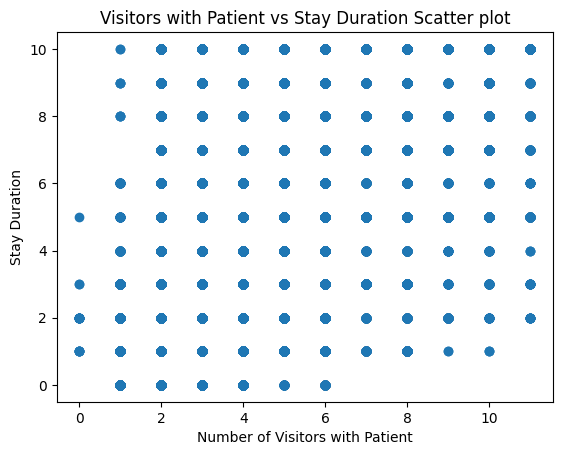

In [111]:
# Visualizing number of visitors and stay duration as a scatter plot
plt.scatter(oversampled_data["Visitors with Patient"], oversampled_data["Stay"],
            marker = "o")
plt.title("Visitors with Patient vs Stay Duration Scatter plot")
plt.xlabel("Number of Visitors with Patient")
plt.ylabel("Stay Duration")
plt.show()

Similarly to the scatter plot of Age vs Stay Duration, it can be observed that there is a lack of linearity between the number of vistors and the stay duration, hence it can be concluded that the number of visitors with a patient barely affects the patient's stay duration.

In [77]:
# Get Categorical columns
cat_cols = oversampled_data.select_dtypes(include="object").columns
cat_cols

Index(['Hospital_type_code', 'Ward_Type', 'Type of Admission',
       'Severity of Illness', 'Age'],
      dtype='object')

In [78]:
# Label Encoding data to visualize at a heatmap
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_df = oversampled_data.copy()
for col in cat_cols:
  encoded_df[col] = le.fit_transform(oversampled_data[col])
encoded_df

,Hospital_code,Hospital_type_code,Ward_Type,Type of Admission,Severity of Illness,Visitors with Patient,Age,Stay,Stay_Type
147507,23,0,2,0,1,7,8,10,1
8992,23,0,1,0,1,4,1,2,0
91680,23,0,1,1,1,7,6,7,1
248851,28,1,2,1,1,4,2,9,1
190537,25,4,3,0,1,2,2,6,1
...,...,...,...,...,...,...,...,...,...
205304,27,0,3,1,0,4,5,9,1
33635,10,4,1,0,2,5,7,7,1
216965,27,0,3,1,0,6,0,5,1
1192,15,2,1,2,0,4,5,1,0


In order to visualize all variables on a heatmap as well as use them for machine learning, they must be converted to numerical values, which can be done using label encoding as demonstrated above.

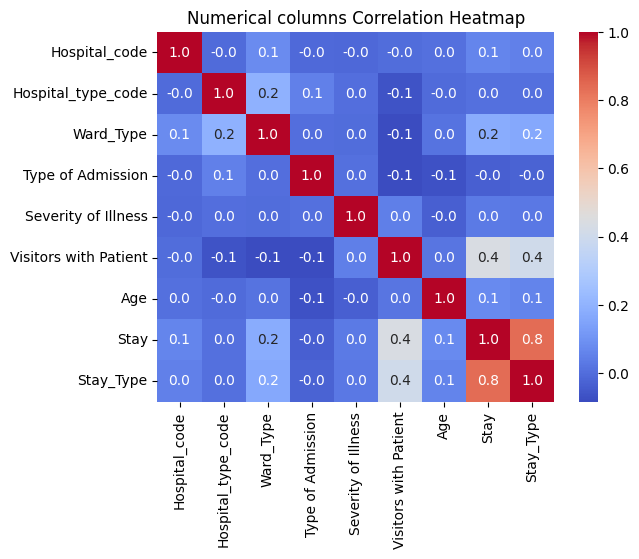

In [79]:
# Correlation of variables with heatmap
correlation_matrix = encoded_df.corr()
sb.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Numerical columns Correlation Heatmap")
plt.show()

As shown in the heatmap above, the variables are truly independent from each other but they also have a very low correlation score with the target variable "Stay_Type", except for "Stay" since "Stay_type" was created based on it. This indicates that within the dataset used, the stay duration is also independent from all the other variables relevant to this research.

# **4.0 Developing ML and DL Prediction Model.**

## **4.1 Data Pre-processing**

In [80]:
# Copying cleaned data
copy_df = oversampled_data.copy()
copy_df

,Hospital_code,Hospital_type_code,Ward_Type,Type of Admission,Severity of Illness,Visitors with Patient,Age,Stay,Stay_Type
147507,23,a,R,Emergency,Minor,7,81-90,10,1
8992,23,a,Q,Emergency,Minor,4,11-20,2,0
91680,23,a,Q,Trauma,Minor,7,61-70,7,1
248851,28,b,R,Trauma,Minor,4,21-30,9,1
190537,25,e,S,Emergency,Minor,2,21-30,6,1
...,...,...,...,...,...,...,...,...,...
205304,27,a,S,Trauma,Extreme,4,51-60,9,1
33635,10,e,Q,Emergency,Moderate,5,71-80,7,1
216965,27,a,S,Trauma,Extreme,6,0-10,5,1
1192,15,c,Q,Urgent,Extreme,4,51-60,1,0


In [112]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(encoded_df)
scaled_df = pd.DataFrame(scaled_data, columns= encoded_df.columns)

The dataset is scaled using a MinMaxScaler so as to convert the values to corresponding values in the range of 0 to 1. This is done in order to avoid feature dominance, thus improving the model's performance.

In [83]:
# Extracting target variable and Exploratory variables
x = scaled_df.loc[:, ~scaled_df.columns.isin(["Stay", "Stay_Type"])]
y = scaled_df["Stay_Type"]
print("Independent variable set shape:", x.shape)
print("Target variable set shape:", y.shape)

Independent variable set shape: (104174, 7)
Target variable set shape: (104174,)


The independant variables and target variables are extracted using the pandas loc function. It can be observed that the code and output above that the independent variables (x) comprise of 7 variables, excluding "Stay" since it is but a more detailed form of "Stay_type" and that the target variable (y) is only one variable.

In [85]:
# Converting to numpy array
y_arr = np.array(y)
x_arr = np.array(x)

The numpy array() fucntion is used to convert the variables into numpy arrays.

In [86]:
# Splitting Dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size = 0.2, random_state = 42)

The dataset is then split in an 80:20 ratio for training and testing sets respectively using the sci-kit learn train_test_split() function.

In [87]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(83339, 7)
(83339,)
(20835, 7)
(20835,)


As shown in the shape outputs above, the training sets contain 83339 rows while the training sets contain 20835 rows, thus confirming the that the split was performed correctly.

## **4.2 Decision Tree Classifier.**

In [88]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
dt = DecisionTreeClassifier()
# Train Model
dt.fit(x_train, y_train)
# Evaluate model
dt_y_pred = dt.predict(x_test)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print("Decision Tree Classifier Accuracy: %.2f" %(dt_accuracy*100), "%")

Decision Tree Classifier Accuracy: 69.92 %


## **4.3 Random Forest Classifier.**

In [89]:
# Model for research question 1
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Train Model
rf.fit(x_train, y_train)
# Evaluate Model
rf_y_pred = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("Random Forest Classifier Accuracy: %.2f" %(rf_accuracy*100), "%")

Random Forest Classifier Accuracy: 71.08 %


## **4.4 KNN Model**

In [115]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
# Initialize the KNN model and specify the number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
# Train the KNN model
knn_model.fit(x_train, y_train)
# Make predictions on the test set
knn_predictions = knn_model.predict(x_test)
# Evaluate the KNN model
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy with 5 neighbours: %.2f" %(knn_accuracy*100), "%")

KNN Accuracy: 70.27 %


In [117]:
# Finding the best k value
best_k = 0
best_accuracy = 0

# Running KNN for K values from 1 to 50
for k in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Updating the best performance
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Best Performance: Accuracy = {best_accuracy*100}, K = {best_k}")

Best Performance: Accuracy = 72.37820974322055, K = 41


Using a loop of evaluating the accuracy, each k value from 1 to 50 was tested for best accuracy and as show in the above output, the best K value was determined to be 41, which yielded an accuracy score of 72.38%, about 2% higher than the accuracy score obtained using a K value of 5.

## **4.5 SVM Model**

In [91]:
from sklearn.svm import SVC
# Initialize the SVM model with a linear kernel
svm_model = SVC(kernel='linear')

# Train the SVM model
svm_model.fit(x_train, y_train)

# Make predictions on the test set
svm_predictions = svm_model.predict(x_test)

# Evaluate the SVM model using mean squared error
svm_mse = mean_squared_error(y_test, svm_predictions)
print("SVM Model Mean Squared Error:", svm_mse)

svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Model Accuracy: %.2f" %(svm_accuracy*100), "%")

SVM Model Mean Squared Error: 0.28860091192704584
SVM Model Accuracy: 71.14 %


## **4.6 keras neural network**

In [92]:
from keras.models import Sequential
from keras.layers import Dense
# create neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
# train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)
# Evaluating the model
keras_accuracy = model.evaluate(x_test, y_test)[1]
print("Keras Neural Network Accuracy: %.2f" %(keras_accuracy*100), "%")


Epoch 1/10
2605/2605 [==============================] - 7s 2ms/step - loss: 0.5752 - accuracy: 0.7104
Epoch 2/10
2605/2605 [==============================] - 5s 2ms/step - loss: 0.5589 - accuracy: 0.7244
Epoch 3/10
2605/2605 [==============================] - 6s 2ms/step - loss: 0.5567 - accuracy: 0.7249
Epoch 4/10
2605/2605 [==============================] - 5s 2ms/step - loss: 0.5549 - accuracy: 0.7266
Epoch 5/10
2605/2605 [==============================] - 6s 2ms/step - loss: 0.5539 - accuracy: 0.7274
Epoch 6/10
2605/2605 [==============================] - 6s 2ms/step - loss: 0.5528 - accuracy: 0.7293
Epoch 7/10
2605/2605 [==============================] - 7s 3ms/step - loss: 0.5519 - accuracy: 0.7293
Epoch 8/10
2605/2605 [==============================] - 7s 3ms/step - loss: 0.5509 - accuracy: 0.7297
Epoch 9/10
2605/2605 [==============================] - 5s 2ms/step - loss: 0.5498 - accuracy: 0.7320
Epoch 10/10
652/652 [==============================] - 1s 2ms/step - loss: 0.5435 

In [113]:
from keras.layers import Dropout
# Keras neural network with 2 hidden layers
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim= x_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))  # Add Dropout layer to prevent overfitting
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid')) # Set the activation function of the output layer to 'sigmoid'

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

model.fit(x_train, y_train, epochs=10, batch_size=32)

keras_accuracy1= model.evaluate(x_test,y_test)[1]
print("Keras Neural Network with 2 hidden layers Accuracy:%.2f"%(keras_accuracy1*100),"%")





Epoch 1/10
2605/2605 [==============================] - 10s 3ms/step - loss: 0.5847 - accuracy: 0.7057
Epoch 2/10
2605/2605 [==============================] - 10s 4ms/step - loss: 0.5635 - accuracy: 0.7257
Epoch 3/10
2605/2605 [==============================] - 10s 4ms/step - loss: 0.5602 - accuracy: 0.7283
Epoch 4/10
2605/2605 [==============================] - 7s 3ms/step - loss: 0.5586 - accuracy: 0.7298
Epoch 5/10
2605/2605 [==============================] - 11s 4ms/step - loss: 0.5564 - accuracy: 0.7300
Epoch 6/10
2605/2605 [==============================] - 7s 3ms/step - loss: 0.5557 - accuracy: 0.7323
Epoch 7/10
2605/2605 [==============================] - 7s 3ms/step - loss: 0.5549 - accuracy: 0.7320
Epoch 8/10
2605/2605 [==============================] - 9s 4ms/step - loss: 0.5535 - accuracy: 0.7313
Epoch 9/10
2605/2605 [==============================] - 9s 3ms/step - loss: 0.5526 - accuracy: 0.7321
Epoch 10/10
652/652 [==============================] - 2s 2ms/step - loss: 0.5

In [96]:
# Keras neural network with 4 hidden layers
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim= x_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))  # Add Dropout layer to prevent overfitting
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid')) # Set the activation function of the output layer to 'sigmoid'

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

model.fit(x_train, y_train, epochs=10, batch_size=32)

keras_accuracy2= model.evaluate(x_test,y_test)[1]
print("Keras Neural Network with 4 hidden layers Accuracy:%.2f"%(keras_accuracy2*100),"%")

Epoch 1/10
2605/2605 [==============================] - 9s 3ms/step - loss: 0.6144 - accuracy: 0.6773
Epoch 2/10
2605/2605 [==============================] - 7s 3ms/step - loss: 0.5892 - accuracy: 0.7118
Epoch 3/10
2605/2605 [==============================] - 8s 3ms/step - loss: 0.5854 - accuracy: 0.7155
Epoch 4/10
2605/2605 [==============================] - 9s 3ms/step - loss: 0.5801 - accuracy: 0.7180
Epoch 5/10
2605/2605 [==============================] - 11s 4ms/step - loss: 0.5799 - accuracy: 0.7181
Epoch 6/10
2605/2605 [==============================] - 11s 4ms/step - loss: 0.5780 - accuracy: 0.7192
Epoch 7/10
2605/2605 [==============================] - 11s 4ms/step - loss: 0.5770 - accuracy: 0.7206
Epoch 8/10
2605/2605 [==============================] - 9s 3ms/step - loss: 0.5755 - accuracy: 0.7211
Epoch 9/10
2605/2605 [==============================] - 7s 3ms/step - loss: 0.5753 - accuracy: 0.7220
Epoch 10/10
652/652 [==============================] - 1s 2ms/step - loss: 0.54

## **4.7 Model Comparison**

In [118]:
print("Decision Tree Classifier Accuracy: %.2f" %(dt_accuracy*100), "%")
print("Random Forest Classifier Accuracy: %.2f" %(rf_accuracy*100), "%")
print("KNN Accuracy: %.2f" %(best_accuracy*100), "%")
print("SVM Model Accuracy: %.2f" %(svm_accuracy*100), "%")
print("Keras Neural Network Accuracy: %.2f" %(keras_accuracy*100), "%")
print("Keras Neural Network with 2 hidden layers Accuracy:%.2f"%(keras_accuracy1*100),"%")
print("Keras Neural Network with 4 hidden layers Accuracy:%.2f"%(keras_accuracy2*100),"%")

Decision Tree Classifier Accuracy: 69.92 %
Random Forest Classifier Accuracy: 71.08 %
KNN Accuracy: 72.38 %
SVM Model Accuracy: 71.14 %
Keras Neural Network Accuracy: 73.80 %
Keras Neural Network with 2 hidden layers Accuracy:73.94 %
Keras Neural Network with 4 hidden layers Accuracy:73.32 %


From the output above, it can be observed that the Keras neural network model with 2 hidden layers using the "relu" activation function yielded the highest accuracy with an accuracy score of 73.94%. Thus it can be concluded that a keras neural network using 2 hidden layers with the relu activation function is the best model among the rest for predicting whether a patient will be staying for a short or long duration based on their number of visitors, age, admission type, ward type, hospital code, hospital type and severity of illness.

